# Fine tuning
We will try to fine tune a pre-trained model for image classification for our road segmentation problem.  
The model we will use is DenseNet-121 which achieve 74.91% top1 accuracy for Imagenet dataset. It achieves a decent accuracy on this latter and is relatively small compares to its other iteration (DenseNet-161, DenseNet-169) or other big network (ResNet-152).

In [15]:
%matplotlib inline
import pickle
import matplotlib.image as mpimg
import matplotlib.patches as matplotlib_patches
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import keras
from sklearn.model_selection import train_test_split
import warnings
from functions_v1 import *

warnings.filterwarnings('ignore')

## Loading our data set

In [10]:
with open( "pickle/X.pickle", "rb" ) as f:
    X = pickle.load(f)

with open( "pickle/Y_categorical.pickle", "rb" ) as f:
    Y_categorical = pickle.load(f)
    
with open( "pickle/Y_labels.pickle", "rb" ) as f:
    Y_labels = pickle.load(f)


## Data preprocessing
We preprocess our data to make it compatible for the pre-trained model.

In [3]:
# Switch RGB to BGR order 
X = X[:, :, :, ::-1]  

# Subtract ImageNet mean pixel 
X[:, :, :, 0] -= 103.939
X[:, :, :, 1] -= 116.779
X[:, :, :, 2] -= 123.68

In [11]:
X.shape

(6250, 64, 64, 3)

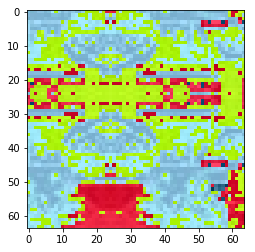

In [5]:
plt.imshow(X[0]);

## Fine tuning

### The model
We use the code from [this repository](https://github.com/flyyufelix/cnn_finetune) to achieve our task.

In [8]:
from keras.optimizers import SGD
from keras.layers import Input, merge, ZeroPadding2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
import keras.backend as K

from sklearn.metrics import log_loss

from custom_layers.scale_layer import Scale

def densenet121_model(img_rows, img_cols, color_type=1, nb_dense_block=4, growth_rate=32, nb_filter=64, reduction=0.5, dropout_rate=0.0, weight_decay=1e-4, num_classes=None):
    '''
    DenseNet 121 Model for Keras

    Model Schema is based on 
    https://github.com/flyyufelix/DenseNet-Keras

    ImageNet Pretrained Weights 
    Theano: https://drive.google.com/open?id=0Byy2AcGyEVxfMlRYb3YzV210VzQ
    TensorFlow: https://drive.google.com/open?id=0Byy2AcGyEVxfSTA4SHJVOHNuTXc

    # Arguments
        nb_dense_block: number of dense blocks to add to end
        growth_rate: number of filters to add per dense block
        nb_filter: initial number of filters
        reduction: reduction factor of transition blocks.
        dropout_rate: dropout rate
        weight_decay: weight decay factor
        classes: optional number of classes to classify images
        weights_path: path to pre-trained weights
    # Returns
        A Keras model instance.
    '''
    eps = 1.1e-5

    # compute compression factor
    compression = 1.0 - reduction

    # Handle Dimension Ordering for different backends
    global concat_axis
    if K.image_dim_ordering() == 'tf':
      concat_axis = 3
      img_input = Input(shape=(img_rows, img_cols, color_type), name='data')
    else:
      concat_axis = 1
      img_input = Input(shape=(color_type, img_rows, img_cols), name='data')

    # From architecture for ImageNet (Table 1 in the paper)
    nb_filter = 64
    nb_layers = [6,12,24,16] # For DenseNet-121

    # Initial convolution
    x = ZeroPadding2D((3, 3), name='conv1_zeropadding')(img_input)
    x = Convolution2D(nb_filter, 7, 7, subsample=(2, 2), name='conv1', bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv1_bn')(x)
    x = Scale(axis=concat_axis, name='conv1_scale')(x)
    x = Activation('relu', name='relu1')(x)
    x = ZeroPadding2D((1, 1), name='pool1_zeropadding')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1')(x)

    # Add dense blocks
    for block_idx in range(nb_dense_block - 1):
        stage = block_idx+2
        x, nb_filter = dense_block(x, stage, nb_layers[block_idx], nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

        # Add transition_block
        x = transition_block(x, stage, nb_filter, compression=compression, dropout_rate=dropout_rate, weight_decay=weight_decay)
        nb_filter = int(nb_filter * compression)

    final_stage = stage + 1
    x, nb_filter = dense_block(x, final_stage, nb_layers[-1], nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

    x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv'+str(final_stage)+'_blk_bn')(x)
    x = Scale(axis=concat_axis, name='conv'+str(final_stage)+'_blk_scale')(x)
    x = Activation('relu', name='relu'+str(final_stage)+'_blk')(x)

    x_fc = GlobalAveragePooling2D(name='pool'+str(final_stage))(x)
    x_fc = Dense(1000, name='fc6')(x_fc)
    x_fc = Activation('softmax', name='prob')(x_fc)

    model = Model(img_input, x_fc, name='densenet')

    if K.image_dim_ordering() == 'th':
      # Use pre-trained weights for Theano backend
      weights_path = 'imagenet_models/densenet121_weights_th.h5'
    else:
      # Use pre-trained weights for Tensorflow backend
      weights_path = 'imagenet_models/densenet121_weights_tf.h5'

    model.load_weights(weights_path, by_name=True)

    # Truncate and replace softmax layer for transfer learning
    # Cannot use model.layers.pop() since model is not of Sequential() type
    # The method below works since pre-trained weights are stored in layers but not in the model
    x_newfc = GlobalAveragePooling2D(name='pool'+str(final_stage))(x)
    x_newfc = Dense(num_classes, name='fc6')(x_newfc)
    x_newfc = Activation('softmax', name='prob')(x_newfc)

    model = Model(img_input, x_newfc)

    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


def conv_block(x, stage, branch, nb_filter, dropout_rate=None, weight_decay=1e-4):
    '''Apply BatchNorm, Relu, bottleneck 1x1 Conv2D, 3x3 Conv2D, and option dropout
        # Arguments
            x: input tensor 
            stage: index for dense block
            branch: layer index within each dense block
            nb_filter: number of filters
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    '''
    eps = 1.1e-5
    conv_name_base = 'conv' + str(stage) + '_' + str(branch)
    relu_name_base = 'relu' + str(stage) + '_' + str(branch)

    # 1x1 Convolution (Bottleneck layer)
    inter_channel = nb_filter * 4  
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x1_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_x1_scale')(x)
    x = Activation('relu', name=relu_name_base+'_x1')(x)
    x = Convolution2D(inter_channel, 1, 1, name=conv_name_base+'_x1', bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    # 3x3 Convolution
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x2_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_x2_scale')(x)
    x = Activation('relu', name=relu_name_base+'_x2')(x)
    x = ZeroPadding2D((1, 1), name=conv_name_base+'_x2_zeropadding')(x)
    x = Convolution2D(nb_filter, 3, 3, name=conv_name_base+'_x2', bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x


def transition_block(x, stage, nb_filter, compression=1.0, dropout_rate=None, weight_decay=1E-4):
    ''' Apply BatchNorm, 1x1 Convolution, averagePooling, optional compression, dropout 
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_filter: number of filters
            compression: calculated as 1 - reduction. Reduces the number of feature maps in the transition block.
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    '''

    eps = 1.1e-5
    conv_name_base = 'conv' + str(stage) + '_blk'
    relu_name_base = 'relu' + str(stage) + '_blk'
    pool_name_base = 'pool' + str(stage) 

    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_scale')(x)
    x = Activation('relu', name=relu_name_base)(x)
    x = Convolution2D(int(nb_filter * compression), 1, 1, name=conv_name_base, bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    x = AveragePooling2D((2, 2), strides=(2, 2), name=pool_name_base)(x)

    return x


def dense_block(x, stage, nb_layers, nb_filter, growth_rate, dropout_rate=None, weight_decay=1e-4, grow_nb_filters=True):
    ''' Build a dense_block where the output of each conv_block is fed to subsequent ones
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_layers: the number of layers of conv_block to append to the model.
            nb_filter: number of filters
            growth_rate: growth rate
            dropout_rate: dropout rate
            weight_decay: weight decay factor
            grow_nb_filters: flag to decide to allow number of filters to grow
    '''

    eps = 1.1e-5
    concat_feat = x

    for i in range(nb_layers):
        branch = i+1
        x = conv_block(concat_feat, stage, branch, growth_rate, dropout_rate, weight_decay)
        concat_feat = merge([concat_feat, x], mode='concat', concat_axis=concat_axis, name='concat_'+str(stage)+'_'+str(branch))

        if grow_nb_filters:
            nb_filter += growth_rate

    return concat_feat, nb_filter

### Fine tuning using our dataset

In [ ]:
def load_data():
    x_train, x_test, y_train, y_test = train_test_split(X, Y_categorical, test_size=0.1, random_state=42)
    return x_train, y_train, x_test, y_test

In [9]:
img_rows, img_cols = 64, 64 # Resolution of inputs
channel = 3
num_classes = 2 
batch_size = 1 
nb_epoch = 1

X_train, Y_train, X_valid, Y_valid = load_data()

# Load our model
model = densenet121_model(img_rows=img_rows, img_cols=img_cols, color_type=channel, num_classes=num_classes)

# Start Fine-tuning
model.fit(X_train, Y_train,
          batch_size=batch_size,
          nb_epoch=nb_epoch,
          shuffle=True,
          verbose=1,
          validation_data=(X_valid, Y_valid),
          )

C:\Users\Coac\Anaconda3\lib\site-packages\ipykernel\__main__.py:57: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (7, 7), name="conv1", strides=(2, 2), use_bias=False)`
C:\Users\Coac\Anaconda3\lib\site-packages\tensorflow\python\util\tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
C:\Users\Coac\Anaconda3\lib\site-packages\ipykernel\__main__.py:130: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), name="conv2_1_x1", use_bias=False)`
C:\Users\Coac\Anaconda3\lib\site-packages\ipykernel\__main__.py:140: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), name="conv2_1_x2", use_bias=False)`
C:\Users\Coac\Anaconda3\lib\site-packages\ipykernel\__main__.py:196: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `k

C:\Users\Coac\Anaconda3\lib\site-packages\ipykernel\__main__.py:140: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), name="conv4_2_x2", use_bias=False)`
C:\Users\Coac\Anaconda3\lib\site-packages\ipykernel\__main__.py:130: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), name="conv4_3_x1", use_bias=False)`
C:\Users\Coac\Anaconda3\lib\site-packages\ipykernel\__main__.py:140: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), name="conv4_3_x2", use_bias=False)`
C:\Users\Coac\Anaconda3\lib\site-packages\ipykernel\__main__.py:130: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), name="conv4_4_x1", use_bias=False)`
C:\Users\Coac\Anaconda3\lib\site-packages\ipykernel\__main__.py:140: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), name="conv4_4_x2", use_bias=False)`
C:\Users\Coac\Anaconda3\lib\site-packages\ipykernel\__main__.py:130: UserWarni

C:\Users\Coac\Anaconda3\lib\site-packages\ipykernel\__main__.py:130: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), name="conv5_1_x1", use_bias=False)`
C:\Users\Coac\Anaconda3\lib\site-packages\ipykernel\__main__.py:140: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), name="conv5_1_x2", use_bias=False)`
C:\Users\Coac\Anaconda3\lib\site-packages\ipykernel\__main__.py:130: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), name="conv5_2_x1", use_bias=False)`
C:\Users\Coac\Anaconda3\lib\site-packages\ipykernel\__main__.py:140: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), name="conv5_2_x2", use_bias=False)`
C:\Users\Coac\Anaconda3\lib\site-packages\ipykernel\__main__.py:130: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), name="conv5_3_x1", use_bias=False)`
C:\Users\Coac\Anaconda3\lib\site-packages\ipykernel\__main__.py:140: UserWarn

Train on 5625 samples, validate on 625 samples
Epoch 1/1
625/625 [==============================] - 69s 110ms/step


In [18]:
# Make predictions
predictions = model.predict(X_train[:625], batch_size=batch_size, verbose=1)

625/625 [==============================] - 63s 101ms/step


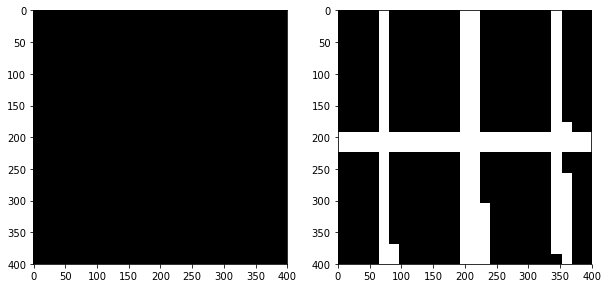

In [34]:
predictions_classes = probas_to_classes(predictions)

image_size = 400
patch_size = 16
image_index = 0

patch_count_per_image = int((image_size / 16) ** 2) 
fig1 = plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
pred_img = label_to_img(image_size, image_size, patch_size, patch_size, predictions_classes)
plt.imshow(pred_img, cmap='Greys_r');
plt.subplot(1, 2, 2)
gt_image = label_to_img(image_size, image_size, patch_size, patch_size, Y_labels[image_index * patch_count_per_image: (image_index+1) * patch_count_per_image])
plt.imshow(gt_image, cmap='Greys_r');
